In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.distributions as tdist
from scipy.special import kv, kve, kvp
from scipy.special import kv as kv_scipy
from torch.autograd import gradcheck

custom_params = {"axes.spines.right": True, "axes.spines.top": True}
sns.set_theme(style="ticks", font_scale=0.8, rc=custom_params)
%config InlineBackend.figure_format="retina"

Scipy implements `kv` and `kve`, and `kvp` (derivative of `kv`). 
 - ${\tt{kv}}(z) = {\tt{kve}}(z)e^{-z} \implies \log({\tt{kv}}(z)) = \log({\tt{kve}}(z)) - z$
 - $\frac{\partial {\tt{kv}}(z)}{\partial z} = \frac{\partial {\tt{kve}}(z)}{\partial z}e^{-z} - {\tt{kve}}(z)e^{-z} = {\tt{kvp}}(z) \implies \frac{\partial {\tt{kve}}(z)}{\partial z} = {\tt{kvp}}(z)e^{z} + {\tt{kve}}(z)$

Other relationships:
 - $\frac{\partial {\log({\tt{kv}}(z))}}{\partial z} = \frac{1}{{\tt{kv}}(z)} {\tt{kvp}}(z)$

The GAL distribution: $g(x) = \frac{2e^{x^T \Sigma^{-1} \mu}}{(2\pi)^{p/2} |\Sigma|^{1/2}} \left( \frac{x^T \Sigma^{-1} x}{2 + \mu^T \Sigma^{-1} \mu} \right)^{\nu/2} K_\nu \left( \sqrt{(2 + \mu^T \Sigma^{-1} \mu)(x^T \Sigma^{-1} x)} \right)$

Log-likelihood: $\ln g(x) = \ln(2) + x^T \Sigma^{-1} \mu - \frac{p}{2} \ln(2\pi) - \frac{1}{2} \ln|\Sigma| + \frac{\nu}{2} \ln\left(\frac{x^T \Sigma^{-1} x}{2 + \mu^T \Sigma^{-1} \mu}\right) + \ln K_\nu\left(\sqrt{(2 + \mu^T \Sigma^{-1} \mu)(x^T \Sigma^{-1} x)}\right)$

In [2]:
class Kv(torch.autograd.Function):
    """
    Modified Bessel function of the second kind, using scipy under the hood.
    Allows use of Kv as a pytorch function.

    Args:
        v : float tensor, order of Bessel functions (also handles integer order)
        z : float tensor, Argument at which to evaluate the Bessel functions
    Returns:
        out : float tensor
    """

    @staticmethod
    def forward(ctx, nu, input):
        ctx.save_for_backward(nu, input)
        input_cpu = input.cpu()
        nu_cpu = nu.cpu()
        out = kv(nu_cpu, input_cpu)
        out = torch.as_tensor(out, dtype=input.dtype, device=input.device)
        return out

    @staticmethod
    def backward(ctx, grad_output):
        nu, input = ctx.saved_tensors
        nu_cpu = nu.cpu()
        input_cpu = input.cpu()
        out = kvp(nu_cpu, input_cpu)
        out = torch.as_tensor(out, dtype=input.dtype, device=input.device)
        return None, grad_output * out


class Kve(torch.autograd.Function):
    """
    Modified Bessel function of the second kind, using scipy under the hood.
    Allows use of Kve as a pytorch function.

    Args:
        v : float tensor, order of Bessel functions (also handles integer order)
        z : float tensor, Argument at which to evaluate the Bessel functions
    Returns:
        out : float tensor
    """

    @staticmethod
    def forward(ctx, nu, z):
        z_cpu = z.cpu()
        nu_cpu = nu.cpu()
        kvez = torch.as_tensor(kve(nu_cpu, z_cpu), dtype=z.dtype, device=z.device)
        ctx.save_for_backward(nu, z, kvez)
        return kvez

    @staticmethod
    def backward(ctx, grad_output):
        nu, z, kvez = ctx.saved_tensors
        kvpz = torch.as_tensor(kvp(nu.cpu(), z.cpu()), dtype=z.dtype, device=z.device)
        out = kvpz * torch.exp(z) + kvez
        return None, grad_output * out

In [3]:
# tests for forward and backward passes
# gradcheck tests the gradient computation against numerical derivatives; requires double precision (float64).


def test_Kv_forward(dtype):  # noqa: N802
    nu = torch.tensor([0.5, 1.0, 2.0], dtype=dtype)
    z = torch.tensor([140.0, 2.5, 3.0], dtype=dtype)
    kv_torch = Kv.apply(nu, z)
    kv_scipy = kv(nu.cpu().numpy(), z.cpu().numpy())
    assert torch.allclose(kv_torch.cpu(), torch.tensor(kv_scipy, dtype=dtype), atol=1e-5)
    return


def test_Kv_backward(dtype):  # noqa: N802
    nu = torch.tensor([0.5], dtype=dtype, requires_grad=False)
    z = torch.tensor([140.0], dtype=dtype, requires_grad=True)
    # Kv.apply(nu, z).backward()
    # print(z.grad)
    # z.grad.zero_()
    assert gradcheck(Kv.apply, (nu, z), eps=1e-6, atol=1e-4)


def test_Kve_forward(dtype):  # noqa: N802
    nu = torch.tensor([0.5], dtype=dtype)
    z = torch.tensor([140.0], dtype=dtype)
    kve_torch = Kve.apply(nu, z)
    kve_scipy = kve(nu.cpu().numpy(), z.cpu().numpy())
    assert torch.allclose(kve_torch.cpu(), torch.tensor(kve_scipy, dtype=dtype), atol=1e-5)
    return


def test_Kve_backward(dtype):  # noqa: N802
    nu = torch.tensor([0.5], dtype=dtype, requires_grad=False)
    z = torch.tensor([140.0], dtype=dtype, requires_grad=True)
    # Kve.apply(nu, z).backward()
    # print(f"gradient: {z.grad}")
    # z.grad.zero_()
    assert gradcheck(Kve.apply, (nu, z), eps=1e-6, atol=1e-4)
    return


test_Kv_forward(dtype=torch.float64)
test_Kv_backward(dtype=torch.float64)
test_Kve_forward(dtype=torch.float64)
test_Kve_backward(dtype=torch.float64)

In [4]:
# check range of values
z = 140
print(f"kv:      {kv(0.5, z)}")
print(f"same as: {kve(0.5, z) * np.exp(-z)}")
print(f"kvp: {kvp(0.5, z)}")
print(f"kvep: {kvp(0.5, z) * np.exp(z) + kve(0.5, z)}")

kv:      1.674050111778709e-62
same as: 1.674050111778709e-62
kvp: -1.6800288621779187e-62
kvep: -0.00037830134845129315


In [5]:
def get_gal_log_likelihood_numpy(X, loc, mu, sigma):
    d = mu.size
    nu = (2 - d) / 2
    diff = X - loc[None]
    Sinv = np.linalg.inv(sigma)
    m_Sinv_m = np.einsum("i,ij,j", mu, Sinv, mu)
    x_Sinv_x = np.einsum("ni,ij,nj -> n", diff, Sinv, diff)
    x_Sinv_m = np.einsum("ni,ij,j -> n", diff, Sinv, mu)
    z = np.sqrt((2 + m_Sinv_m) * x_Sinv_x)

    log_prob = (
        math.log(2)
        + x_Sinv_m
        - 0.5 * d * math.log(2 * math.pi)
        - 0.5 * np.linalg.slogdet(sigma)[1]
        + 0.5 * nu * np.log(x_Sinv_x / (2 + m_Sinv_m))
        + np.log(kve(nu, z))
        - z
    )
    return log_prob


def get_gal_log_likelihood_kve(X, loc, mu, sigma):
    d = mu.size(0)
    nu = torch.as_tensor((2 - d) / 2)
    diff = X - loc[None]
    Sinv = torch.inverse(sigma)
    m_Sinv_m = torch.einsum("i,ij,j", mu, Sinv, mu)
    x_Sinv_x = torch.einsum("ni,ij,nj -> n", diff, Sinv, diff)
    x_Sinv_m = torch.einsum("ni,ij,j -> n", diff, Sinv, mu)
    z = torch.sqrt((2 + m_Sinv_m) * x_Sinv_x)
    log_prob = (
        math.log(2)
        + x_Sinv_m
        - 0.5 * d * math.log(2 * math.pi)
        - 0.5 * torch.logdet(sigma)
        + 0.5 * nu * torch.log(x_Sinv_x / (2 + m_Sinv_m))
        + torch.log(Kve.apply(nu, z))
        - z
    )
    return log_prob


def get_gal_likelihood_kv(X, loc, mu, sigma):
    d = mu.size(0)
    nu = torch.as_tensor((2 - d) / 2)
    diff = X - loc[None]
    Sinv = torch.inverse(sigma)
    m_Sinv_m = torch.einsum("i,ij,j", mu, Sinv, mu)
    x_Sinv_x = torch.einsum("ni,ij,nj -> n", diff, Sinv, diff)
    x_Sinv_m = torch.einsum("ni,ij,j -> n", diff, Sinv, mu)
    z = torch.sqrt((2 + m_Sinv_m) * x_Sinv_x)
    log_prob = (
        math.log(2)
        + x_Sinv_m
        - 0.5 * d * math.log(2 * math.pi)
        - 0.5 * torch.logdet(sigma)
        + 0.5 * nu * torch.log(x_Sinv_x / (2 + m_Sinv_m))
        + torch.log(Kv.apply(nu, z))
    )
    return log_prob


def sample_gal(n_samples, loc, mu, sigma):
    """Following section 6.4 of Kotz (2001)
    1. Generate a standard exponential variate W.
    2. Independently of W , generate multivariate normal Nd(0, Σ) variate N.
    3. Set Y ← m· W + √W· N.
    """
    dim = mu.size(0)
    W = tdist.Exponential(rate=1.0).sample(sample_shape=(n_samples,))
    N = tdist.MultivariateNormal(loc=torch.zeros(dim), covariance_matrix=sigma).sample(sample_shape=(n_samples,))
    X = torch.einsum("n, i -> ni", W, mu) + torch.einsum("n, ni -> ni", torch.sqrt(W), N) + loc
    return X


def get_cov(S, m):
    """Covariance for GAL"""
    return S + m @ m.T


def chol_to_cov(chol_params):
    """
    Get the covariance matrix from the Cholesky parameters.
    """
    diagonals = torch.nn.functional.softplus(torch.diagonal(chol_params, 0, -2, -1)) + 1e-4
    chol = torch.diag_embed(diagonals) + torch.tril(chol_params, -1)
    cov = chol @ chol.T
    return cov


def get_2d_densities(X, num_bins, bin_range):
    num_samples = X.shape[0]
    (counts, x_edges, y_edges) = np.histogram2d(X[:, 0], X[:, 1], num_bins, range=bin_range)
    density = counts / num_samples / (x_edges[1] - x_edges[0]) ** 2
    x_grid = (x_edges[:-1] + x_edges[1:]) / 2
    y_grid = (y_edges[:-1] + y_edges[1:]) / 2
    (x_coords, y_coords) = np.meshgrid(x_grid, y_grid, indexing="ij")
    return (density, x_coords, y_coords)

1d check:

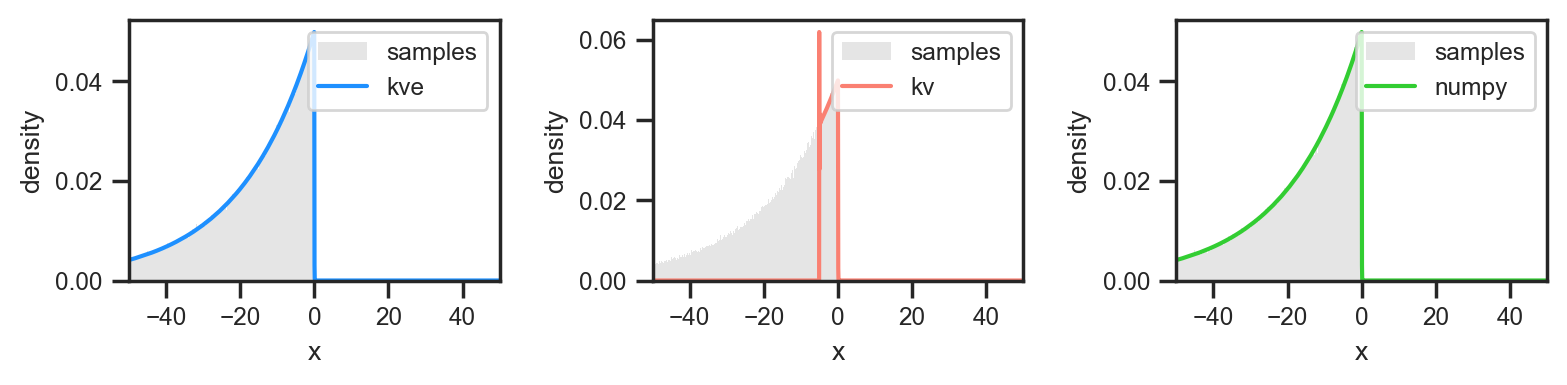

In [6]:
f, ax = plt.subplots(1, 3, figsize=(8, 2))

mu = torch.as_tensor([-20.0])
loc = torch.as_tensor([-0.0])
sigma = torch.as_tensor([[1.0]])
X = sample_gal(500000, loc, mu, sigma)
grid = torch.linspace(-100, 100, 10000)[:, None]

probs_numpy = np.exp(get_gal_log_likelihood_numpy(grid.numpy(), loc.numpy(), mu.numpy(), sigma.numpy()))
probs_kve = torch.exp(get_gal_log_likelihood_kve(grid, loc, mu, sigma))
probs_kv = torch.exp(get_gal_likelihood_kv(grid, loc, mu, sigma))

ax[0].hist(X, 2000, density=True, facecolor="gray", edgecolor="None", alpha=0.2, label="samples")
ax[0].plot(grid, probs_kve, c="dodgerblue", label="kve")

ax[1].hist(X, 2000, density=True, facecolor="gray", edgecolor="None", alpha=0.2, label="samples")
ax[1].plot(grid, probs_kv, c="salmon", label="kv")

ax[2].hist(X, 2000, density=True, facecolor="gray", edgecolor="None", alpha=0.2, label="samples")
ax[2].plot(grid, probs_numpy, c="limegreen", label="numpy")

for axs in ax:
    axs.set(xlim=(-50, 50), xlabel="x", ylabel="density")
    axs.legend(loc="upper right")
plt.tight_layout()
plt.show()

 - Version with Kv fails (related to numerical precision) for when $\Sigma$ is small and $\mu$ is large. 
 - Re-writing with Kve fixes at least the forward pass. 
 - Backward for Kve contains a $e^z$ term - may need to revisit this!
 - No issues with `gradcheck` for Kv or Kve;

2d distribution:

In [7]:
num_samples = 50000
loc = torch.as_tensor([5.01, 7.12])
mu = torch.as_tensor([5.0, 2.0])
sigma = 1.0 * chol_to_cov(torch.ones([2, 2]))
samples = sample_gal(num_samples, loc, mu, sigma)
(density, x_grid, y_grid) = get_2d_densities(samples, num_bins=1000, bin_range=[[0, 20], [0, 20]])

flat_grid = torch.tensor(np.stack([x_grid.reshape(-1), y_grid.reshape(-1)], 1), dtype=torch.float32)
prob_grid = torch.exp(get_gal_log_likelihood_kve(flat_grid, loc, mu, sigma))
prob_grid = prob_grid.reshape(x_grid.shape)

# subsample for scatter plot
ind = np.random.choice(np.arange(num_samples), 1000)

print(np.max(prob_grid.detach().numpy().ravel()))
print(np.min(prob_grid.detach().numpy().ravel()))

0.6599729
8.2698e-41


In [8]:
# covariance is a function of mu and sigma fro GAL
cov = get_cov(sigma, mu.reshape(-1, 1))
cov = cov.detach().numpy()

In [9]:
# principal axes of covariance (not sigma)
eigvals, eigvecs = np.linalg.eig(cov)
rot_mat = eigvecs.T @ np.diag(1 / np.sqrt(eigvals))
rotated_cov = rot_mat @ cov @ rot_mat.T

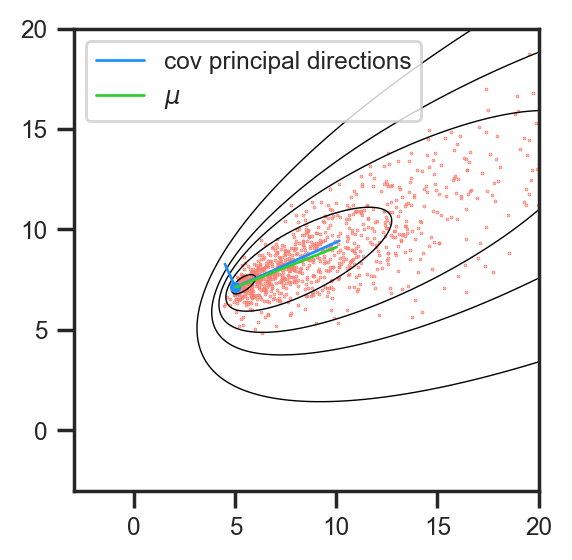

In [10]:
scaled_eigvecs = eigvecs * eigvals**0.5  # length is std deviation.
scale = 1
f, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.contour(
    x_grid,
    y_grid,
    prob_grid.detach().numpy(),
    levels=[0.000001, 0.0001, 0.001, 0.01, 0.1, 0.5],
    colors="black",
    linewidths=0.5,
)
ax.scatter(samples[ind, 0], samples[ind, 1], alpha=1, s=0.1, c="salmon")
ax.plot(loc[0], loc[1], ".", c="dodgerblue")
ax.plot(
    [loc[0], loc[0] + scaled_eigvecs[0, 0] * scale],
    [loc[1], loc[1] + scaled_eigvecs[1, 0] * scale],
    c="dodgerblue",
    linewidth=1,
)
ax.plot(
    [loc[0], loc[0] + scaled_eigvecs[0, 1] * scale],
    [loc[1], loc[1] + scaled_eigvecs[1, 1] * scale],
    c="dodgerblue",
    linewidth=1,
    label="cov principal directions",
)
ax.plot([loc[0], loc[0] + mu[0]], [loc[1], loc[1] + mu[1]], c="limegreen", linewidth=1, label=r"$\mu$")
ax.set(xlim=(-3, 20), ylim=(-3, 20))
ax.legend(loc="upper left")
plt.show()

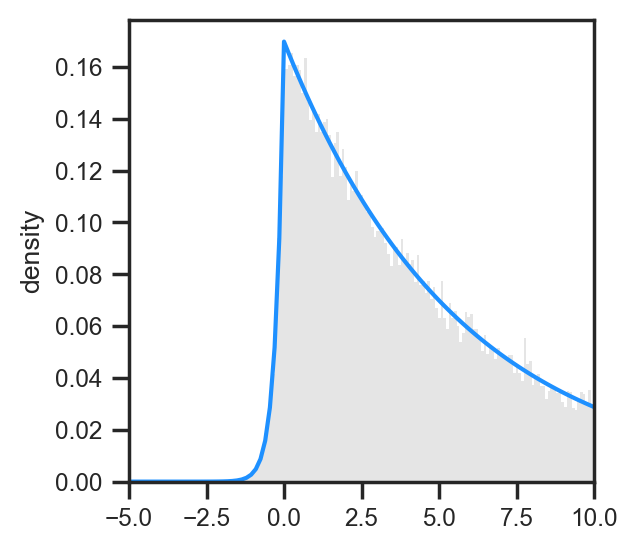

In [11]:
# project samples onto the first eigenvector;
samples_proj = (samples - loc.reshape(1, -1)) @ eigvecs[:, 0]
samples_proj = samples_proj.detach().numpy()

# project parameters:
A = eigvecs[:, 0].T
loc_proj = torch.as_tensor([0.0])
mu_proj = torch.as_tensor([A @ mu.detach().numpy()])
sigma_proj = torch.as_tensor([[A @ sigma.detach().numpy() @ A.T]])
x = torch.linspace(-5, 10, 100)[:, None]
y = np.exp(get_gal_log_likelihood_kve(x, loc_proj, mu_proj, sigma_proj))

# plot projected samples and density.
f, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.hist(samples_proj, 1000, density=True, facecolor="gray", edgecolor="None", alpha=0.2, label="samples")
ax.set(xlim=(-5, 10), ylabel="density")
ax.plot(x, y, c="dodgerblue", label="kve")
ax.set(xlim=(-5, 10), ylabel="density")
plt.show()

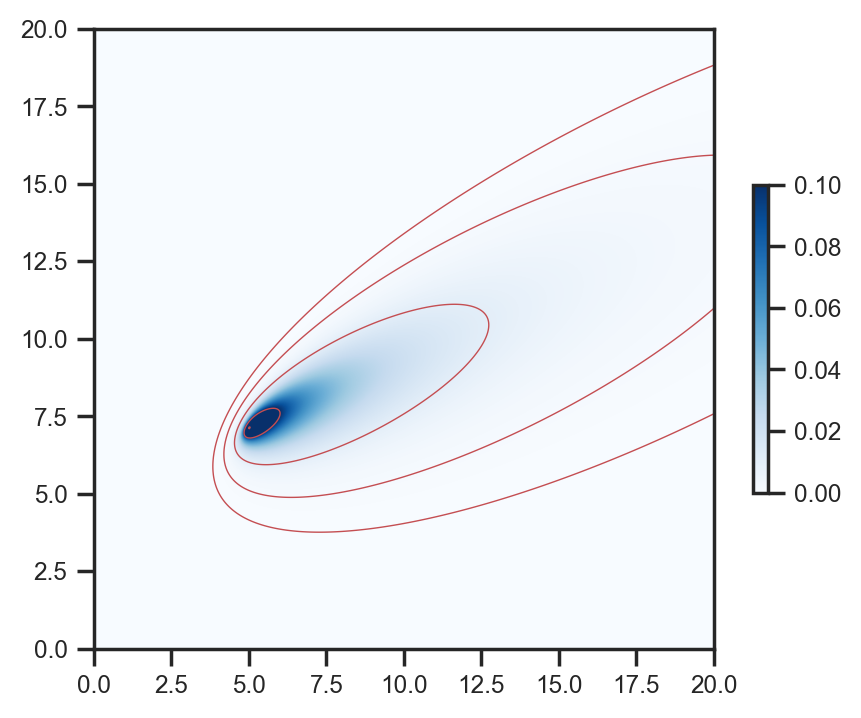

In [12]:
f, ax = plt.subplots(1, 1, figsize=(5, 5))
im = ax.imshow(
    prob_grid.detach().numpy().T,
    vmin=0,
    vmax=0.1,
    extent=[x_grid.min(), x_grid.max(), y_grid.min(), y_grid.max()],
    origin="lower",
    cmap="Blues",
)
ax.contour(
    x_grid,
    y_grid,
    prob_grid.detach().numpy(),
    levels=[1e-4, 1e-3, 1e-2, 0.1, 0.5],
    colors="r",
    linewidths=0.5,
    origin="lower",
)
ax.set(xlim=(0, 20), ylim=(0, 20))
plt.colorbar(im, shrink=0.4)
plt.show()

Optimization:

In [13]:
num_samples = 50000
dim = 2
loc = torch.ones([dim]) * 2
mu = torch.ones([dim])
sigma = chol_to_cov(torch.ones([dim, dim]))

In [14]:
loc_params = torch.nn.Parameter(torch.ones([dim]))
mu_params = torch.nn.Parameter(torch.zeros([dim]))
chol_params = torch.nn.Parameter(torch.eye(dim))

(loc_start, mu_start, sigma_start) = (loc_params.clone(), mu_params.clone(), chol_to_cov(chol_params))

In [15]:
samples = sample_gal(num_samples, loc, mu, sigma)
(density, x_grid, y_grid) = get_2d_densities(samples, num_bins=1000, bin_range=[[-5, 15], [-5, 15]])

In [16]:
optim = torch.optim.Adam([loc_params, mu_params, chol_params])
num_epochs = 2000
try:  # Training can be gracefully ended early by interrupting the cell execution
    for epoch in range(num_epochs):
        optim.zero_grad()
        loss = -get_gal_log_likelihood_kve(samples, loc_params, mu_params, chol_to_cov(chol_params)).mean()
        loss.backward()
        optim.step()
        print(f"Epoch {epoch + 1}/{num_epochs} -- {loss:.4f}            ", end="\r")
except KeyboardInterrupt:
    pass
(loc_opt, mu_opt, sigma_opt) = (loc_params.clone(), mu_params.clone(), chol_to_cov(chol_params))

In [17]:
flat_grid = torch.tensor(np.stack([x_grid.reshape(-1), y_grid.reshape(-1)], 1), dtype=torch.float32)

with torch.no_grad():
    prob_grid_true = torch.exp(get_gal_log_likelihood_kve(flat_grid, loc, mu, sigma)).reshape(x_grid.shape)
    prob_grid_start = torch.exp(get_gal_log_likelihood_kve(flat_grid, loc_start, mu_start, sigma_start)).reshape(
        x_grid.shape
    )
    prob_grid_opt = torch.exp(get_gal_log_likelihood_kve(flat_grid, loc_opt, mu_opt, sigma_opt)).reshape(x_grid.shape)

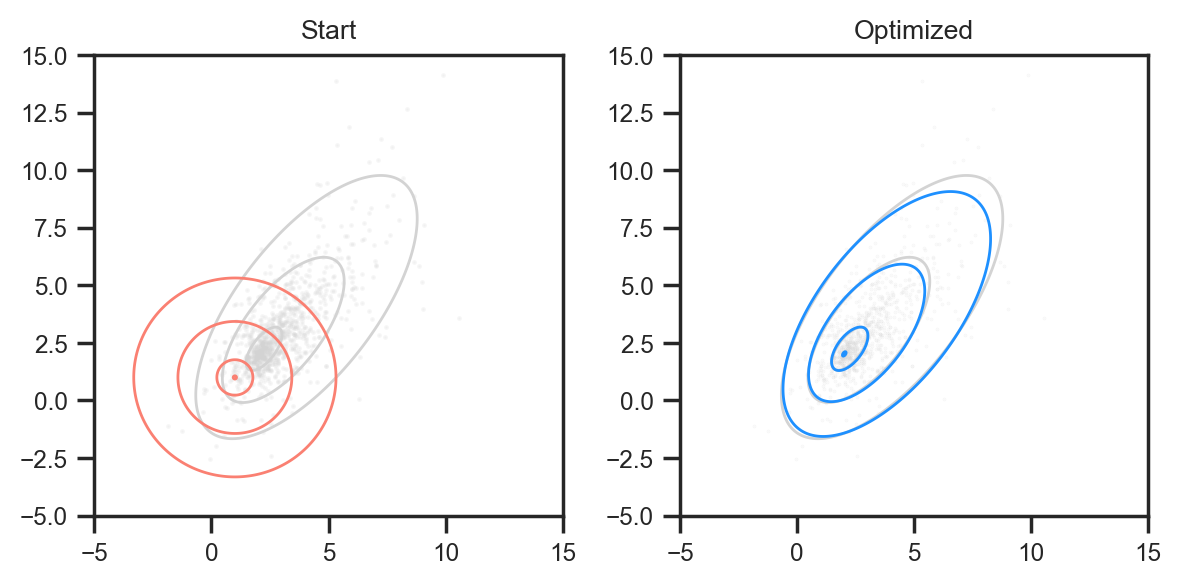

In [18]:
levels = [0.001, 0.01, 0.1, 0.5]
ind = np.random.choice(np.arange(num_samples), 1000)

f, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].contour(x_grid, y_grid, prob_grid_true.detach().numpy(), levels=levels, colors="lightgray", linewidths=1)
ax[0].contour(x_grid, y_grid, prob_grid_start.detach().numpy(), levels=levels, colors="salmon", linewidths=1)
ax[0].scatter(samples[ind, 0], samples[ind, 1], alpha=0.2, s=0.5, c="lightgray")
ax[0].set(title="Start")

ax[1].contour(x_grid, y_grid, prob_grid_true.detach().numpy(), levels=levels, colors="lightgray", linewidths=1)
ax[1].contour(x_grid, y_grid, prob_grid_opt.detach().numpy(), levels=levels, colors="dodgerblue", linewidths=1)
ax[1].scatter(samples[ind, 0], samples[ind, 1], alpha=0.2, s=0.1, c="lightgray")
ax[1].set(title="Optimized")

for axs in ax:
    axs.set(xlim=(-5, 15), ylim=(-5, 15))

plt.tight_layout()
plt.show()

In [19]:
loc_opt.detach(), mu_opt.detach(), sigma_opt.detach()

(tensor([2.0080, 2.0141]),
 tensor([0.8636, 0.8251]),
 tensor([[1.4838, 1.0180],
         [1.0180, 2.3099]]))

In [20]:
loc, mu, sigma

(tensor([2., 2.]),
 tensor([1., 1.]),
 tensor([[1.7249, 1.3134],
         [1.3134, 2.7249]]))